<a href="https://colab.research.google.com/github/DaliaAlzubi/Kidney_Tumor/blob/main/3_Models_Detection_1Exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## steps : 

1. read Data (excel file ) from google drive , images 
2. unzip images file
3. read images 
4. preparation
4. split data to  taring 80 % , testing 20%
5. normalization images
6. building model
7. compile model 
8. fit model 
9. test model
10. Plot the results

In [ ]:
import seaborn as sns; sns.set(color_codes=True)  # visualization tool
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import statistics
import collections
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import display 
from sklearn.ensemble import AdaBoostClassifier
import keras
from keras.models import Sequential , Model
from keras.layers import (
                          Dense,
                          Add,
                          Conv2D,
                          MaxPool2D,
                          Flatten,
                          Dropout,
                          MaxPooling2D,
                          Input,
                          Conv2DTranspose,
                          Concatenate,
                          BatchNormalization,
                          UpSampling2D,
                          AveragePooling2D,
                          GlobalAveragePooling2D,
                          Activation,
                          ZeroPadding2D
                      )
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam , SGD
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools
import shutil
from tensorflow.keras.models import Model, load_model
import imutils
from tensorflow.keras import optimizers
import cv2 as cv
import seaborn as sns
from random import choices
from keras.applications.vgg16 import VGG16 
from keras.applications.resnet50 import ResNet50
from keras.initializers import glorot_uniform

In [ ]:
!unzip sample_data/images_data.zip -d sample_data/

Streaming output truncated to the last 5000 lines.
  inflating: sample_data/Dalia_Data/35/00000125.jpg  
  inflating: sample_data/Dalia_Data/35/00000126.jpg  
  inflating: sample_data/Dalia_Data/35/0000012B.jpg  
  inflating: sample_data/Dalia_Data/35/0000012E.jpg  
  inflating: sample_data/Dalia_Data/35/0000012F.jpg  
  inflating: sample_data/Dalia_Data/35/0000014B.jpg  
  inflating: sample_data/Dalia_Data/35/0000014D.jpg  
  inflating: sample_data/Dalia_Data/35/0000014F.jpg  
  inflating: sample_data/Dalia_Data/35/00000151.jpg  
  inflating: sample_data/Dalia_Data/35/00000152.jpg  
  inflating: sample_data/Dalia_Data/35/0000018B.jpg  
  inflating: sample_data/Dalia_Data/35/0000018C.jpg  
  inflating: sample_data/Dalia_Data/35/0000019E.jpg  
  inflating: sample_data/Dalia_Data/35/000001A1.jpg  
  inflating: sample_data/Dalia_Data/35/000001A4.jpg  
  inflating: sample_data/Dalia_Data/35/000001A5.jpg  
  inflating: sample_data/Dalia_Data/35/000001A6.jpg  
  inflating: sample_data/Dalia_

# Read Data 

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
patient_info = drive.CreateFile({'id':"1dN1peOSeugjLLzzazh4yGoy_g1LBlzp7"})
patient_info.GetContentFile("patient_info.csv")
patient_info = pd.read_csv("patient_info.csv")

# Tumor Detection

In [ ]:
patient_info["Tumor_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_label":{'Null':0  , "Benign":1 , 'Malignant':1 }
}
patient_info = patient_info.replace(cleanup_nums)
del cleanup_nums

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Patient_ID                       120 non-null    object
 1   Patient_Num                      120 non-null    int64 
 2   Age                              120 non-null    int64 
 3   Gender                           120 non-null    object
 4   Test                             120 non-null    object
 5   Date                             120 non-null    int64 
 6   Taking_Contrast                  120 non-null    object
 7   Clinical_data                    120 non-null    object
 8   Symptoms                         120 non-null    object
 9   Diagnosing_test                  120 non-null    object
 10  Diagnosing_Right_Kidney          120 non-null    object
 11  Injure_range_Right_K_in_Details  120 non-null    object
 12  Segmentation_Right               120

In [ ]:
patient_info.sample(5)

,Patient_ID,Patient_Num,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Tumor_label
6,KA00123709,7,68,Female,CT ABDOMEN PELVIS,2020,Yes,Not provided,Flank pain,"Stable left sided adrenal lesion, splenomegaly","Bulky, cyst","Bulky, cyst 0.5 x 0.7 cm","Renal pelvit, Midportion",Tissue adrenal,Lesion ardenal 2 x 1.4 x 1.6 cm,Upper portion,I,Tumor,Benign,Adenoma,1
87,KA00017549,88,59,Male,CT ABDOMEN PELVIS,2020,Yes,Radical nephrectomy,Not provided,Kidney Cyst,Cyst,Tiny renal cyst,Upper portion,Nephrectomy,"Non-visualize, radical nephrectomy",Undefined,Null,Normal case with cyst,Null,Null,0
108,KA00017541,109,52,Male,CT ABDOMEN PELVIS,2021,No,Not provided,Flank pain,Multipe stone,"Hydronephrosis, stone","Stone 0.4 cm, hydronephrosis 1 cm",Middle calyceal,Stone,Small stone,Undefined,Null,Normal case,Null,Null,0
66,KA00157061,67,70,Male,CT ABDOMEN PELVIS,2020,Yes,Cancer big toe,Not provided,"Lesions liver 3.3 x 4.2 cm and 4.2 x 4.7 cm,",Cyst,cyst 1.9 x 1.7 cm,Upper pole,Healthy,Healthy,Undefined,Null,Normal case with cyst,Null,Null,0
11,KA00021437,12,74,Female,CT ABDOMEN PELVIS,2021,Yes,"Diabetes, Hypertension, Heart disease",Not provided,"Tissue lung, soft tissue lesions seen arising ...",Tissue adrenal,Calcification,Undefined,Tissue adrenal,Lesion adrenal 1.6 X 1.1 X 1.6 cm,Upper portion,I,Tumor,Benign,Adenoma,1


In [ ]:
def crop_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
  
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [ ]:
labels = {0:"Normal" , 1:"Tumor"}

In [ ]:
def get_data (data_dir , target ):
    X = list()
    y=list()
    img_size = 256
    for index, row in patient_info.iterrows():
        path = os.path.join(data_dir, str (row['Patient_Num']))
        label = row[target]
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size   
                
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(e , row['Patient_Num'] )
    return X , y

X , y  = get_data("sample_data/Dalia_Data/", target = "Tumor_label")

In [ ]:
dict(zip(list(y),[list(y).count(i) for i in list(y)]))

{0: 4200, 1: 4200}

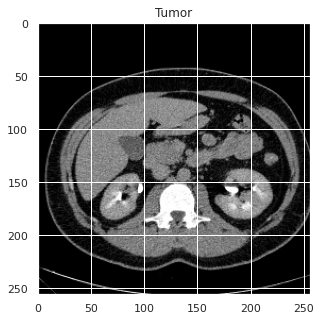

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[20])
plt.title(labels[y[20]])
plt.show()

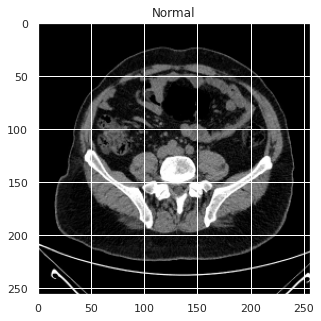

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[6000])
plt.title(labels[y[6000]])
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test , test_size = 0.10)     # we need to change this to train and validate!!!!!!!!!!!!!!!!!

In [ ]:
print ("Number images for training : {}".format(len (x_train)) , dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)])) )
print ("Number images for testing : {}".format(len (x_test)), dict(zip(list(y_test),[list(y_test).count(i) for i in list(y_test)])) )
print ("Number images for Validation : {}".format(len (x_val)) ,  dict(zip(list(y_val),[list(y_val).count(i) for i in list(y_val)])) )

Number images for training : 5880 {1: 2952, 0: 2928}
Number images for testing : 2268 {1: 1133, 0: 1135}
Number images for Validation : 252 {0: 137, 1: 115}


In [ ]:
def data_prepare (X , y , folder_name , labels ) :
    path = "sample_data/{}".format(folder_name)
    os.mkdir(path)
    # create folder for labels 
    for key , value in labels.items()  : 
        path = "sample_data/{}/{}".format(folder_name,value)
        os.mkdir(path)

    if len (X) != len (y) : 
      print ("error size data X and y is not equal")
      return 

    for index , value in enumerate(y) : 
      im = Image.fromarray(X[index])
      path = "sample_data/{}/{}/{}.jpeg".format(folder_name,labels[value],str(index))
      im.save(path)
    return 

In [ ]:
data_prepare (X=x_train ,y=y_train ,folder_name="train", labels=labels )
data_prepare (X=x_test ,y=y_test ,folder_name="test", labels=labels )
data_prepare (X=x_val ,y=y_val ,folder_name="validation", labels=labels )

In [ ]:
## Genration Images 

train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/sample_data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory('/content/sample_data/test',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 5880 images belonging to 2 classes.
Found 2268 images belonging to 2 classes.


# my model

In [ ]:
class AccuracyStopping(keras.callbacks.Callback):
    def __init__(self, acc_threshold):
        super(AccuracyStopping, self).__init__()
        self._acc_threshold = acc_threshold

    def on_epoch_end(self, batch, logs={}):
        train_acc = logs.get('accuracy')
        print(train_acc)
        value=1-train_acc
        print(value)
        self.model.stop_training = value <= self._acc_threshold

acc_callback = AccuracyStopping(0.02)

def get_Model():
    modelName= Sequential()
    modelName.add(BatchNormalization(input_shape = (224,224,3)))
    modelName.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
    modelName.add(MaxPooling2D(pool_size = (2, 2)))
    modelName.add(Dropout(0.25))
    modelName.add(Flatten())
    modelName.add(Dense(units = 128, activation = 'relu'))
    modelName.add(Dense(units = 2, activation = 'softmax'))
    return modelName

x=get_Model()

x.compile(
    optimizer='adam' , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']    )

history = x.fit(    
          training_set,
          steps_per_epoch = (5880 /32),
          epochs=50, 
          validation_data=test_set,           # validation should be validation not testing!!!!!!!!!!!!!!!!!!!
          validation_steps = (2268 /32)
                          )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


183/183 [==============================] - 75s 329ms/step - loss: 12.8718 - accuracy: 0.5466 - val_loss: 0.6752 - val_accuracy: 0.6442
Epoch 2/50
183/183 [==============================] - 61s 330ms/step - loss: 0.6228 - accuracy: 0.6539 - val_loss: 0.5543 - val_accuracy: 0.7249
Epoch 3/50
183/183 [==============================] - 61s 331ms/step - loss: 0.5922 - accuracy: 0.6881 - val_loss: 0.5069 - val_accuracy: 0.7535
Epoch 4/50
183/183 [==============================] - 61s 330ms/step - loss: 0.5507 - accuracy: 0.7242 - val_loss: 0.5120 - val_accuracy: 0.7513
Epoch 5/50
183/183 [==============================] - 61s 334ms/step - loss: 0.5636 - accuracy: 0.7061 - val_loss: 0.6101 - val_accuracy: 0.6887
Epoch 6/50
183/183 [==============================] - 61s 329ms/step - loss: 0.5215 - accuracy: 0.7412 - val_loss: 0.4659 - val_accuracy: 0.7778
Epoch 7/50
183/183 [==============================] - 60s 329ms/step - loss: 0.5359 - accuracy: 0.7282 - val_loss: 0.4508 - val_accuracy: 0.

In [ ]:
x.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=x.evaluate(test_set)                           # how is that, it is correct but you are using trained data to be tested!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

71/71 [==============================] - 4s 53ms/step - loss: 0.1508 - accuracy: 0.9502
Test Loss     = 0.15079465508460999
Test Accuracy = 0.9501763582229614


<Figure size 1080x1080 with 0 Axes>

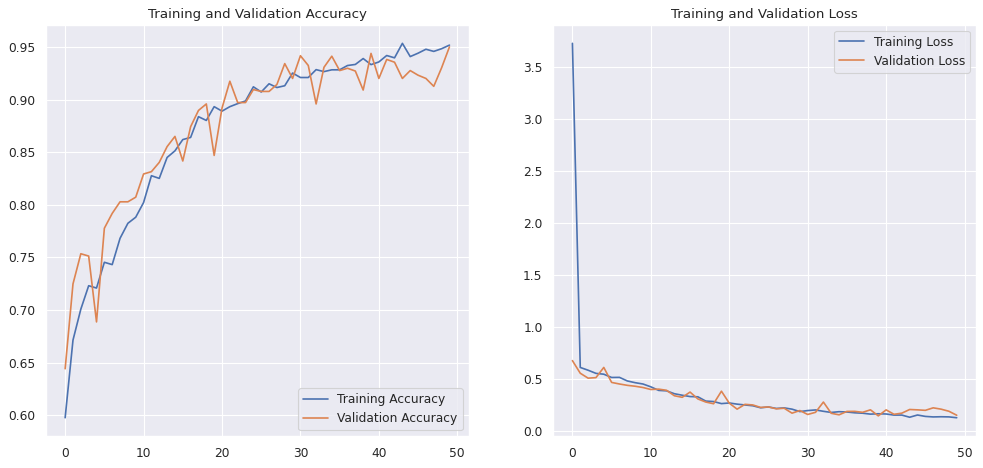

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))

fig, ax = plt.subplots(figsize = (15 ,15) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')  
ax.spines['bottom'].set_color('#000000')

plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Number of images for Normal : 124


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 116, 'Tumor': 8}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


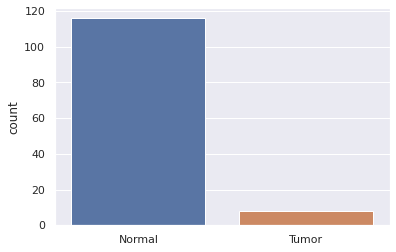

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2'] 

path='/content/sample_data/validation/Normal'
l_Normal =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

l_Normal_result=[]
for i in range(len(l_Normal)):
  xx = x.predict_classes(l_Normal[i])
  l_Normal_result.append(xx)

l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)




res = dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)]))
labels = ['Normal','Tumor']

fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()


sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

Number of images for Tumor : 128


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 7, 'Tumor': 121}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


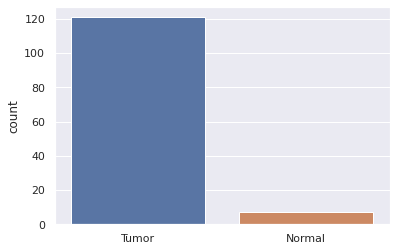

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/validation/Tumor'
l_Tumor=[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

l_Tumor_result=[]
for i in range(len(l_Tumor)):
  xx = x.predict_classes(l_Tumor[i])
  l_Tumor_result.append(xx)

l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94       124
       Tumor       0.94      0.95      0.94       128

    accuracy                           0.94       252
   macro avg       0.94      0.94      0.94       252
weighted avg       0.94      0.94      0.94       252



In [ ]:
x.save('/content/drive/MyDrive/Tumer_classification/best_model.h5')

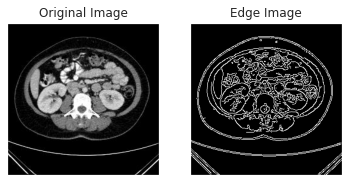

In [ ]:
path='sample_data/validation/Normal/124.jpeg'
path2='/sample_data/validation/Tumor/110.jpeg'
img=cv2.imread(path)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

# VGG16

In [ ]:
datagen = ImageDataGenerator(rescale=1/255,
                             rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             width_shift_range=0.1,
                             shear_range=0.1,
                             brightness_range=[0.3, 1.5],
                             validation_split=0.2
                            )

train_gen= datagen.flow_from_directory('/content/sample_data/train',
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='training'
                                      )
val_gen = datagen.flow_from_directory( '/content/sample_data/test',          # What is this???????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                                       target_size=(224,224),
                                       class_mode='binary',
                                       subset='validation'
                                      )

Found 4705 images belonging to 2 classes.
Found 452 images belonging to 2 classes.


In [ ]:
vgg_model=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)
model=keras.Sequential()
for layer in vgg_model.layers:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [ ]:
stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history=model.fit(train_gen,validation_data=val_gen,epochs=50,callbacks=[stop,checkpoint])

Epoch 1/50
148/148 [==============================] - 70s 474ms/step - loss: 0.2516 - accuracy: 0.8884 - val_loss: 0.2006 - val_accuracy: 0.9314
Epoch 2/50
148/148 [==============================] - 69s 469ms/step - loss: 0.2623 - accuracy: 0.8852 - val_loss: 0.2266 - val_accuracy: 0.9159
Epoch 3/50
148/148 [==============================] - 69s 466ms/step - loss: 0.2405 - accuracy: 0.8956 - val_loss: 0.2501 - val_accuracy: 0.8827
Epoch 4/50
148/148 [==============================] - 69s 464ms/step - loss: 0.2419 - accuracy: 0.8950 - val_loss: 0.2107 - val_accuracy: 0.9226
Epoch 5/50
148/148 [==============================] - 72s 486ms/step - loss: 0.2506 - accuracy: 0.8965 - val_loss: 0.2443 - val_accuracy: 0.8982
Epoch 6/50
148/148 [==============================] - 73s 491ms/step - loss: 0.2422 - accuracy: 0.9001 - val_loss: 0.1694 - val_accuracy: 0.9381
Epoch 7/50
148/148 [==============================] - 71s 476ms/step - loss: 0.2416 - accuracy: 0.8978 - val_loss: 0.2002 - val_ac

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=model.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

71/71 [==============================] - 4s 59ms/step - loss: 29.8189 - accuracy: 0.7077
Test Loss     = 29.81885528564453
Test Accuracy = 0.7076719403266907


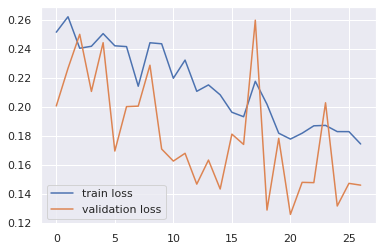

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()

Number of images for Normal : 134


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 110, 'Tumor': 24}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


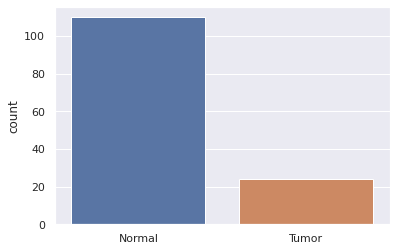

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/validation/Normal'
l_Normal =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

l_Normal_result=[]
for i in range(len(l_Normal)):
  xx = model.predict_classes(l_Normal[i])
  l_Normal_result.append(xx)

l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

Number of images for Tumor : 118


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 45, 'Tumor': 73}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


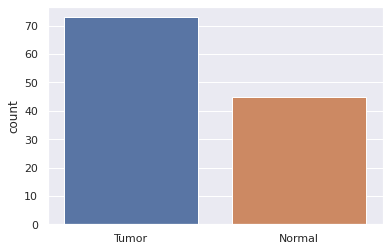

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/validation/Tumor'
l_Tumor=[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

l_Tumor_result=[]
for i in range(len(l_Tumor)):
  xx = model.predict_classes(l_Tumor[i])
  l_Tumor_result.append(xx)

l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result

x_results_new = list()
for i in x_results :
  x_results_new.append(i[0][0])

print(classification_report( y_labels , x_results_new , target_names=target_names))

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.71      0.82      0.76       134
       Tumor       0.75      0.62      0.68       118

    accuracy                           0.73       252
   macro avg       0.73      0.72      0.72       252
weighted avg       0.73      0.73      0.72       252



# ResNet50

In [ ]:
#add RESNet Model as a layer in ou model as we use in the structure above 

stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

base_model_2 = Sequential()
base_model_2.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model_2.add(Dropout(0.25))
base_model_2.add(Flatten())
base_model_2.add(Dense(units = 128, activation = 'relu'))
base_model_2.add(Dense(2, activation='softmax'))


base_model_2.compile(
    optimizer='adam' , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']    )


In [ ]:
base_model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1402 (ModuleW (32, 224, 224, 3)         0         
_________________________________________________________________
module_wrapper_1403 (ModuleW (32, 230, 230, 3)         0         
_________________________________________________________________
module_wrapper_1404 (ModuleW (32, 112, 112, 64)        9472      
_________________________________________________________________
module_wrapper_1405 (ModuleW (32, 112, 112, 64)        256       
_________________________________________________________________
module_wrapper_1406 (ModuleW (32, 112, 112, 64)        0         
_________________________________________________________________
module_wrapper_1407 (ModuleW (32, 114, 114, 64)        0         
_________________________________________________________________
module_wrapper_1408 (ModuleW (32, 56, 56, 64)         

In [ ]:
history=base_model_2.fit(training_set,validation_data=test_set,epochs=50,callbacks=[stop])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


184/184 [==============================] - 81s 400ms/step - loss: 2.9475 - accuracy: 0.5880 - val_loss: 1.2542 - val_accuracy: 0.5265
Epoch 2/50
184/184 [==============================] - 72s 393ms/step - loss: 0.4636 - accuracy: 0.7657 - val_loss: 0.5805 - val_accuracy: 0.6486
Epoch 3/50
184/184 [==============================] - 73s 393ms/step - loss: 0.3122 - accuracy: 0.8732 - val_loss: 1.5889 - val_accuracy: 0.6243
Epoch 4/50
184/184 [==============================] - 72s 393ms/step - loss: 0.2200 - accuracy: 0.9129 - val_loss: 0.4609 - val_accuracy: 0.8060
Epoch 5/50
184/184 [==============================] - 73s 394ms/step - loss: 0.1873 - accuracy: 0.9334 - val_loss: 0.7530 - val_accuracy: 0.7288
Epoch 6/50
184/184 [==============================] - 72s 393ms/step - loss: 0.1621 - accuracy: 0.9425 - val_loss: 0.4008 - val_accuracy: 0.8686
Epoch 7/50
184/184 [==============================] - 73s 397ms/step - loss: 0.1238 - accuracy: 0.9551 - val_loss: 0.3529 - val_accuracy: 0.8

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Testing Set Clases : ' , test_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Testing Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=base_model_2.evaluate(test_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

71/71 [==============================] - 5s 69ms/step - loss: 0.5638 - accuracy: 0.8593
Test Loss     = 0.5637968182563782
Test Accuracy = 0.8593474626541138


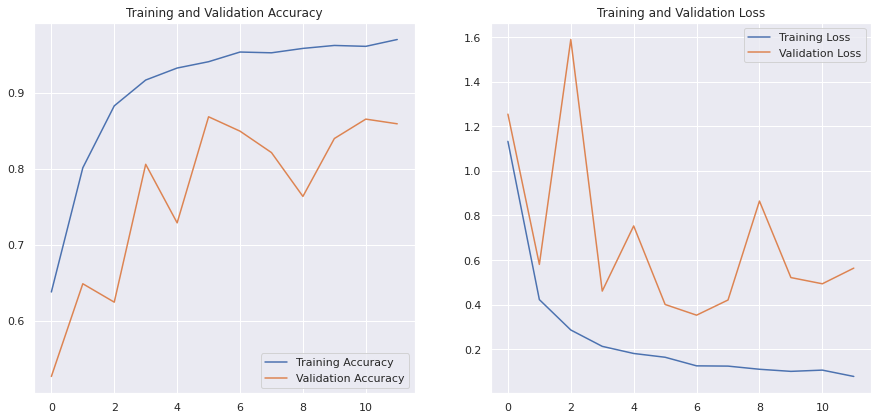

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Number of images for Normal : 124


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 90, 'Tumor': 34}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


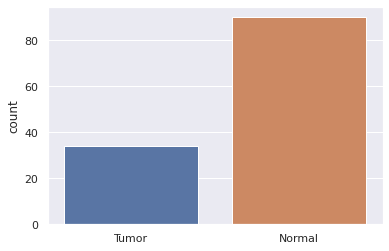

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/validation/Normal'
l_Normal =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

l_Normal_result=[]
for i in range(len(l_Normal)):
  xx = base_model_2.predict_classes(l_Normal[i])
  l_Normal_result.append(xx)

l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i][0] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

Number of images for Tumor : 128


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'=============================='

{'Normal': 5, 'Tumor': 123}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


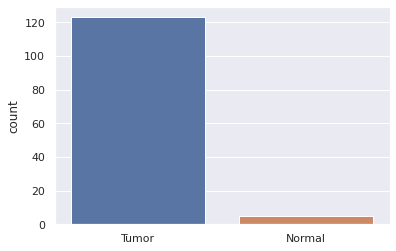

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/validation/Tumor'
l_Tumor=[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

l_Tumor_result=[]
for i in range(len(l_Tumor)):
  xx = base_model_2.predict_classes(l_Tumor[i])
  l_Tumor_result.append(xx)

l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i][0]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(test_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.95      0.73      0.82       124
       Tumor       0.78      0.96      0.86       128

    accuracy                           0.85       252
   macro avg       0.87      0.84      0.84       252
weighted avg       0.86      0.85      0.84       252



In [ ]:
{
    "Tumor_Detection" : {"Traning":5880 , "Testing":2520 ,"Total":8400 } , 
    "Tumor_type_classification" : {"Traning":3360 , "Testing":840 , "Total": 4200  } , 
    "Tumor_Benign_classification" : {"Traning":1657 , "Testing":933 ,"Total": 2590  } , 
    "Tumor_Malignant_classification" : {"Traning":985 , "Testing":555 , "Total": 1540} , 
    "Stages" : {"Traning":2688 , "Testing":1512 , "Total": 4200  } , 
}


Number images for training : 3288
Number images for testing : 406
Number images for Validation : 366

SyntaxError: ignored

In [ ]:
2688 + 1512

4200